# Import modules

In [1]:
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/shoal_densified.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

In [3]:
import h5py

with h5py.File('/home/exouser/project/densifimcation/forcing/20240122_event/2024012200.h5', 'r') as f:
    print(list(f.keys())) 

['data_assimilation__qBtmVertRunoff', 'data_assimilation__qBucket', 'data_assimilation__qSfcLatRunoff', 'data_assimilation__streamflow', 'no_data_assimilation__qBucket', 'no_data_assimilation__qSfcLatRunoff', 'no_data_assimilation__streamflow', 'short_range__qBtmVertRunoff', 'short_range__qBucket', 'short_range__qSfcLatRunoff', 'short_range__streamflow']


In [4]:
key = 'short_range'#'no_data_assimilation'#
# Define path for NWM forcings
forcing_path = '../data/20240122_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20240121', '20240124', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key=key+'__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key=key+'__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key=key+'__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
## Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket
# Format column types
forcing.columns = forcing.columns.astype(str)

In [6]:
forecast_horizon = 18
n_forecasts = len(forcing) // forecast_horizon
reaches = forcing.columns

In [7]:
len(forcing)/18

72.0

In [12]:
starttime = datetime.datetime.now()
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                        in model_collection.models.values()]))


# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_densified_reach_df = pd.read_csv('../data/NWPSGagesTravis_All_Join_to_Densified.csv', index_col=0) [['usgs_id','creek_id']]
# print(usgs_to_densified_reach_df.columns)
usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','creek_id']].reset_index(drop=True).dropna().reset_index(drop=True)
usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['creek_id'].astype(int).astype(str)
# Filter 
usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]
usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)


multi_window_output_da = []


for i in range(n_forecasts):
    block = forcing.iloc[i * forecast_horizon: (i + 1) * forecast_horizon]
    # Create input table with lateral overflow into each modeled reach
    
    input_index = block.index.copy()
    inputs = pd.DataFrame(0., index=input_index, columns=input_columns)
    
    # Fill input table with forcings for each reach
    store = pd.HDFStore('../data/area_fractions.h5', 'r')
    hdf_keys = store.keys()
    store.close()
    for key in hdf_keys:
        comid = key.split('__')[-1]
        area_ratios = pd.read_hdf(f'../data/area_fractions.h5', key=key)
        for reach_id in area_ratios.index:
            if comid in block.columns:
                runoff_proportion = area_ratios.loc[reach_id].item() * block[comid]
                reach_id_str = str(reach_id)
                if reach_id_str in inputs.columns:
                    inputs[reach_id_str] += runoff_proportion
    # Resample forcing input table to frequency of model timestep
    dt = model_collection.timedelta.seconds
    inputs = inputs.resample(f'{dt}s').mean()
    inputs = inputs.interpolate().bfill().ffill()
    assert not inputs.isnull().any().any()

    
    # Load table of USGS gage measurements
    measurements = pd.read_hdf('../data/gages.h5', key='usgs') #pd.read_hdf('../data/gages_usgs_20240121_to_20240124.h5', key='usgs')
    measurements.columns = measurements.columns.astype(int).astype(str) # 596 gages 2020-2024-7
    measurements = measurements[usgs_to_densified_reach.index]
    measurements.columns = measurements.columns.map(usgs_to_densified_reach) # change the column to COMID
    measurements = measurements.loc[forcing.index[0]:forcing.index[-1]] 
    #select the right time period as the forcing
    measurements = measurements.dropna(axis=1) # drop gages without data
    measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]  # 36 gages
    # drop gages where all flow are zeros
    measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
    measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill() 
    measurements

    # Set up Kalman Filtering
    for model in model_collection.models.values():
        # Find subset of gages for each sub-model
        model_sites = [reach_id for reach_id in model.reach_ids 
                        if reach_id in measurements.columns]
        if model_sites:
            # Get subset of measurements for sub-model
            basin_measurements = measurements[model_sites]
            # Process noise covariance matrix
            Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
            # Measurement noise covariance matrix
            R_cov = 1. * np.eye(basin_measurements.shape[1])
            # Initial estimate of error covariance matrix
            P_t_init = Q_cov.copy()
            # Create Kalman Filter
            kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
            # Bind Kalman Filter to model
            model.bind_callback(kf, key='kf')

            
    # Add downstream boundaries to model
    for model in model_collection.models.values():
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)
    
    # Set starting time of each model to just before start of forcings
    timedelta = pd.to_timedelta(dt, unit='s')
    for model_name, model in model_collection.models.items():
        model.datetime = inputs.index[0] - timedelta
    
    # Set up simulation
    simulation = AsyncSimulation(model_collection, inputs)

    # Simulate models
    outputs_da = await simulation.simulate()
    # Collect outputs into a single table
    outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)
    #outputs_da = outputs_da.resample("h").mean()
    print(len(outputs_da))

    multi_window_output_da.append(outputs_da)
endtime = datetime.datetime.now()
print(f"the code took {endtime-starttime} to run")

6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
6122
the code took 1:03:46.870440 to run


In [13]:
len(input_columns)

574

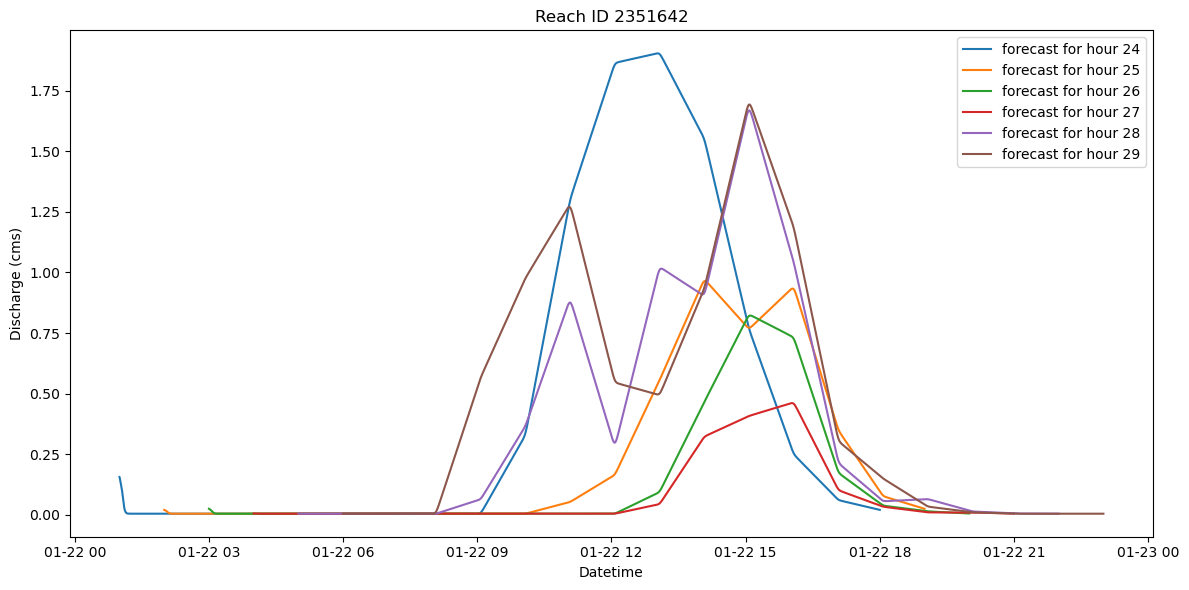

In [22]:
reach_id = input_columns[-1]
# Create a figure
plt.figure(figsize=(12, 6))

# Loop through DataFrames and plot the column
for i, df in enumerate(multi_window_output_da[24:30]):
    if reach_id in df.columns:
        plt.plot(df.index, df[reach_id], label=f'forecast for hour {i+24}')
    else:
        print(f"Reach ID '{reach_id}' not found in DataFrame {i}")

# Add labels and legend
plt.xlabel("Datetime")
plt.ylabel("Discharge (cms)")
plt.title(f"Reach ID {reach_id}")
plt.legend()
plt.tight_layout()
plt.show()